# 1. Introduction

Neural Machine Translation (NMT) is an end-to-end learning approach for automated translation [[1]](https://arxiv.org/abs/1609.08144). Its strength comes from the fact that it learns the mapping directly from input text to associated output text. It has been proven to be more effective than traditional phrase-based machine translation, which requires much more effort to design the model. On the other hand, NMT models are costly to train, especially on large-scale translation datasets. They are also significantly slower at inference time due to the large number of parameters used. Other limitations are its robustness when translating rare words and failing to translate all parts of the input sentence. To overcome these problems, there are already some solutions, such as using the attention mechanism to copy rare words [[2]](https://arxiv.org/abs/1412.2007).

Typically, NMT models follow the common sequence-to-sequence learning architecture. It consists of an encoder and a decoder Recurrent Neural Networks (RNN) (for a simpler example on how to set up an RNN, see [[3]](https://towardsdatascience.com/generating-text-with-recurrent-neural-networks-based-on-the-work-of-f-pessoa-1e804d88692d)). The encoder transforms the input sentence into a list of vectors, one vector per input. Given this list, the decoder produces one output at a time until the special end-of-sentence token is produced.

Our task is to produce translations in Portuguese for input sentences in English, using a medium-size corpus of example pairs. We build our NMT model using a sequence to sequence architecture. For the encoder RNN, we use a pre-trained embedding, a token-based text embedding trained on English Google News 200B corpus [[4]](https://tfhub.dev/google/tf2-preview/nnlm-en-dim128). On the other hand, we train our own embedding in the decoder RNN, with a vocabulary size set to the number of unique Portuguese words in the corpus. Due to the complex architecture of the model, we implement a custom training loop to train our model.

This article uses a dataset that consists of 170,305 sentence pairs in English and Portuguese [[5]](https://www.kaggle.com/luisroque/engpor-sentence-pairs). The data comes from Tatoeba.org, a large database of example sentences translated into many languages by volunteers.

# 2. Preprocessing

We start by adding two special tokens to every sentence in Portuguese, a `<start>` and `<end>` tokens. They are used to signal the beginning and end of a sentence to the decode RNN. Next, we tokenize the Portuguese sentences and pad the end of the sentences with zeros.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer
import matplotlib.pyplot as plt
import unicodedata
import re
import time

In [2]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                 if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    return w

In [3]:
NUM_EXAMPLES = 100000
data_examples = []
with open('eng-por.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

df = pd.DataFrame(data_examples, columns=['all'])
df = df['all'].str.split('\t', expand=True)

df.columns = columns=['english', 'portuguese', 'rest']

df = df[['english', 'portuguese']]

df['portuguese'] = df.apply(lambda row: "<start> " + preprocess_sentence(row['portuguese']) + " <end>", axis=1)
df['english'] = df.apply(lambda row: preprocess_sentence(row['english']), axis=1)

tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

tokenizer.fit_on_texts(df['portuguese'].to_list())

df['portuguese_tokens'] = df.apply(lambda row: 
                        tokenizer.texts_to_sequences([row['portuguese']])[0], axis=1)

# Print 5 examples from each language

idx = np.random.choice(df.shape[0],5)

for i in idx:
    print('English')
    print(df['english'][i])
    
    print('\nportuguese')
    print(df['portuguese'][i])
    print(df['portuguese_tokens'][i])
    print('\n----\n')

portuguese_tokens = tf.keras.preprocessing.sequence.pad_sequences(df['portuguese_tokens'].to_list(),
                                                 padding='post',
                                                 value=0)

portuguese_tokens.shape

FileNotFoundError: [Errno 2] No such file or directory: 'eng-por.txt'

## 2.1 Pre-Trained Embedding Layer

For both the encoder and decoder RNNs, we need to define embedding layers to turn our indices of words into dense vectors of fixed size. For the decoder RNN, we trained our own embedding. For the encoder RNN, we used a pre-trained English word embedding from Tensorflow Hub. It is a token-based text embedding trained on the English Google News 200B corpus. It allows us to leverage a word representation trained on a very large corpus, following the principle of Transfer Learning (see [[6]](https://towardsdatascience.com/transfer-learning-and-data-augmentation-applied-to-the-simpsons-image-dataset-e292716fbd43) for an extended definition and a Transfer Learning application to computer vision). We padded the English sentences before feeding them into the RNN.

In [ ]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
                                 output_shape=[128], input_shape=[], dtype=tf.string)

# Test the layer

embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

In [33]:
maxlen = 13

def split_english(dataset):
    dataset = dataset.map(lambda x, y: (tf.strings.split(x, sep=' '), y))
    return dataset

def filter_func(x,y):
    return (tf.math.less_equal(len(x),maxlen)) 

def map_maxlen(x, y):
    paddings = [[0, maxlen - tf.shape(x)[0]], [0, 0]]
    x = tf.pad(x, paddings, 'CONSTANT', constant_values=0)
    return (x, y)

def embed_english(dataset):
    dataset = dataset.map(lambda x, y: (embedding_layer(x), y))
    return dataset

In [34]:
english_strings = df['english'].to_numpy()
english_string_train, english_string_valid, portuguese_token_train, portuguese_token_valid = train_test_split(english_strings, portuguese_tokens, train_size=0.8)

dataset_train = (embed_english(
                        split_english(
                            tf.data.Dataset.from_tensor_slices((english_string_train, portuguese_token_train)))
                                                                .filter(filter_func))
                                                                .map(map_maxlen)
                                                                .batch(16))
dataset_valid = (embed_english(
                        split_english(
                            tf.data.Dataset.from_tensor_slices((english_string_valid, portuguese_token_valid)))
                                                                .filter(filter_func))
                                                                .map(map_maxlen)
                                                                .batch(16))

dataset_train.element_spec

(TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 16), dtype=tf.int32, name=None))

In [35]:
# shape of the English data example from the training Dataset
list(dataset_train.take(1).as_numpy_iterator())[0][0].shape

(16, 13, 128)

In [36]:
# shape of the portuguese data example Tensor from the validation Dataset
list(dataset_valid.take(1).as_numpy_iterator())[0][1].shape

(16, 16)

# 3. Enconder Recurrent Neural Network

The encoder network is an RNN whose job is to read a sequence of vectors $\textbf{x}=(x_1,...,x_T)$ into a vector $c$, such that:

$$\begin{aligned}h_t = f(x_t, h_{t-1}) \\
c = q({h_1,...,h_T}),
\end{aligned}$$

where $h_t \in \mathbb{R}^n$ is the hidden state at time $t$, $c$ is a vector generated from the sequence of the hidden states and $f$ and $q$ are nonlinear functions.

Before defining our encoder network, we introduced a layer that learns the 128-dimensional representation (the size of the embedding space) of the end token for the English corpus. Therefore, the input dimension to the RNN was increased by 1. The RNN consists of a Long Short-Term Memory (LSTM) layer with 1024 units. Padded values are masked in the RNN, so they are simply ignored. The encoder is a multi-output model: it outputs the hidden state and cell states of the LSTM layer. The output of the LSTM layer is not used in a sequence to sequence architecture.

In [37]:
class EndTokenLayer(Layer):

    def __init__(self, embedding_dim=128, **kwargs):
        super(EndTokenLayer, self).__init__(**kwargs)
        self.end_token_embedding = tf.Variable(initial_value=tf.random.uniform(shape=(embedding_dim,)), trainable=True)

    def call(self, inputs):
        end_token = tf.tile(tf.reshape(self.end_token_embedding, shape=(1, 1, self.end_token_embedding.shape[0])), [tf.shape(inputs)[0],1,1])
        return tf.keras.layers.concatenate([inputs, end_token], axis=1)

In [38]:
end_token_layer = EndTokenLayer()

In [39]:
inputs = tf.keras.Input(shape=(maxlen, 128))
x = end_token_layer(inputs)
x = tf.keras.layers.Masking(mask_value=0)(x)
whole_seq_output, final_memory_state, final_carry_state = tf.keras.layers.LSTM(512, return_sequences=True, return_state=True)(x)
outputs = (final_memory_state, final_carry_state)

In [40]:
encoder_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="encoder_model")
encoder_model.summary()

Model: "encoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 13, 128)]         0         
_________________________________________________________________
end_token_layer_1 (EndTokenL (None, 14, 128)           128       
_________________________________________________________________
masking_1 (Masking)          (None, 14, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                [(None, 14, 512), (None,  1312768   
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_________________________________________________________________


In [41]:
inputs_eng = list(dataset_train.take(1).as_numpy_iterator())[0][0]

In [42]:
memory_state, carry_state = encoder_model(inputs_eng)

# 4. Attention

The attention mechanism that we will be using was proposed by [[7]](https://arxiv.org/pdf/1409.0473.pdf). The main difference of using an attention mechanism is that we increase the expressiveness of the model, especially the encoder component. It no longer needs to encode all the information in the source sentence into a fixed-length vector. The context vector $c_i$ is then computed as:

$$c_i = \sum^{T_x}_{j=1}\alpha_{ij}h_j$$.

The weights $\alpha_{ij}$ are calculated as 

$$\alpha_{ij}=\frac{\exp(e_{ij})}{\sum^{T}_{k=1}\exp(e_{ik})},$$

where $e_{ij}=a(s_{i-1},h_j)$ is the score of how well the inputs around position $j$ and the output at position $i$ match.

In [43]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, hidden_states, cell_states):
        hidden_states_with_time = tf.expand_dims(hidden_states, 1)

        score = self.V(tf.nn.tanh(
            self.W1(hidden_states_with_time) + self.W2(cell_states)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * cell_states
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

# 5. Decoder Recurrent Neural Network

The decoder is trained to predict the next word $y_t$ given the context vector $c$ and all the previously predicted words ${y_1,...,y_{t-1}}$, such that:

$$p(\textbf{y})=\prod^T_{t=1}p(y_t|{y_1,...,y_{t-1}},c)$$

where $\textbf{y}=(y_1,...,y_T)$. For this we use an RNN, which means that each conditional probability is modeled as

$$p(y_t|{y_1,...,y_{t-1}},c)=g(y_{t-1},s_t,c),$$

where $g$ is a nonlinear function and $s_t$ is the hidden state of the RNN.

For the decoder RNN, we defined an embedding layer with the vocabulary size set to the number of unique Portuguese tokens. An LSTM layer followed this embedding layer with 1024 units and a Dense layer with a number of units equal to the number of unique Portuguese tokens and no activation function. Notice that despite the considerably shallow network, as we used only one recurrent layer, we end up with almost 24M parameters to train.

In [44]:
import json
word_index = json.loads(tokenizer.get_config()['word_index'])

max_index_value = max(word_index.values())

In [45]:
class decoder_RNN(tf.keras.Model):
    def __init__(self, **kwargs):
        super(decoder_RNN, self).__init__()
        self.embed = tf.keras.layers.Embedding(input_dim=max_index_value+1, output_dim=128, mask_zero=True)
        self.lstm_1 = tf.keras.layers.LSTM(1024, return_sequences=True, return_state=True)
        self.dense_1 = tf.keras.layers.Dense(max_index_value+1)
        self.attention = Attention(1024)

    def call(self, inputs, training=False, hidden_state=None, cell_state=None):
        context_vector, attention_weights = self.attention(hidden_state, cell_state)
        x = self.embed(inputs)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        x, hidden_state, cell_state = self.lstm_1(x)
        x = self.dense_1(x)
        return x

In [46]:
decoder_model = decoder_RNN()

In [47]:
decoder_model(inputs = tf.random.uniform((16, 1)), hidden_state = memory_state, cell_state = carry_state)
decoder_model.summary()

Model: "decoder_rnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  1789568   
_________________________________________________________________
lstm_3 (LSTM)                multiple                  6819840   
_________________________________________________________________
dense_4 (Dense)              multiple                  14330525  
_________________________________________________________________
attention_1 (Attention)      multiple                  1051649   
Total params: 23,991,582
Trainable params: 23,991,582
Non-trainable params: 0
_________________________________________________________________


# 6. Training

To train a model with a sequence to sequence architecture, we needed to define a custom training loop. First, we defined a function that split the Portuguese corpus into the input and output tensors fed to the decoder model. Secondly, we created the forward and backward passes of the complete model. We passed the English input into the encoder to get the hidden and cell states of the encoder LSTM. These hidden and cell states are then passed into the decoder, along with the Portuguese inputs. We defined the loss function, calculated between the decoder outputs and the Portuguese output previously split, and the computation of the gradients with respect to the encoder and decoder trainable variables. Finally, we ran the training loop for a defined number of epochs. It iterated through the training dataset, creating the decoder inputs and outputs from the Portuguese sequences. It then computed the gradients and updated the parameters of the model accordingly.

The model is quite slow to train, even using GPU. Recall that we did not even stack layers in any of the RNNs, which would reduce our loss but, at the same time, make our model even harder to train. We can see from the plots below that both the training and validation reduced steadily over time.

In [48]:
def portuguese_input_output(data):
    return (tf.cast(data[:,0:-1], tf.float32), tf.cast(data[:,1:], tf.float32))

In [49]:
optimizer_obj = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [50]:
@tf.function
def grad(encoder_model, decoder_model, english_input, portuguese_input, portuguese_output, loss):
    with tf.GradientTape() as tape:
        loss_value = 0
        hidden_state, cell_state = encoder_model(english_input)
        dec_input = tf.expand_dims([word_index['<start>']] * 16, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, portuguese_output.shape[1]):
            predictions = decoder_model(dec_input, hidden_state = hidden_state, cell_state = cell_state)

            loss_value += loss(portuguese_output[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(portuguese_output[:, t], 1)

        grads = tape.gradient(loss_value, encoder_model.trainable_variables + decoder_model.trainable_variables)
    return loss_value, grads

In [51]:
def train_model(encoder_model, decoder_model, num_epochs, train_dataset, valid_dataset, optimizer, loss, grad_fn):
    inputs = (14,)
    train_loss_results = []
    train_loss_results_valid = []
    for epoch in range(num_epochs):
        start = time.time()

        epoch_loss_avg = tf.keras.metrics.Mean()
        
        for x, y in train_dataset:
            dec_inp, dec_out = portuguese_input_output(y)
            loss_value, grads = grad_fn(encoder_model, decoder_model, x, dec_inp, dec_out, loss)
            optimizer.apply_gradients(zip(grads, encoder_model.trainable_variables + decoder_model.trainable_variables))
            epoch_loss_avg(loss_value)

        train_loss_results.append(epoch_loss_avg.result())
        
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch,
                                                  epoch_loss_avg.result()))
        print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')
    return train_loss_results

In [52]:
num_epochs=15
train_loss_results = train_model(encoder_model, decoder_model, num_epochs, dataset_train, dataset_valid, optimizer_obj, loss_obj, grad)

Epoch 000: Loss: 23.192
Time taken for 1 epoch 758.72 sec

Epoch 001: Loss: 19.355
Time taken for 1 epoch 749.01 sec

Epoch 002: Loss: 17.883
Time taken for 1 epoch 748.91 sec

Epoch 003: Loss: 16.368
Time taken for 1 epoch 749.56 sec

Epoch 004: Loss: 12.706
Time taken for 1 epoch 750.83 sec

Epoch 005: Loss: 7.722
Time taken for 1 epoch 746.72 sec

Epoch 006: Loss: 5.026
Time taken for 1 epoch 744.72 sec

Epoch 007: Loss: 3.540
Time taken for 1 epoch 747.66 sec

Epoch 008: Loss: 2.604
Time taken for 1 epoch 748.59 sec

Epoch 009: Loss: 2.002
Time taken for 1 epoch 755.00 sec

Epoch 010: Loss: 1.587
Time taken for 1 epoch 756.13 sec

Epoch 011: Loss: 1.305
Time taken for 1 epoch 752.17 sec

Epoch 012: Loss: 1.116
Time taken for 1 epoch 750.78 sec

Epoch 013: Loss: 0.980
Time taken for 1 epoch 748.11 sec

Epoch 014: Loss: 0.894
Time taken for 1 epoch 749.47 sec



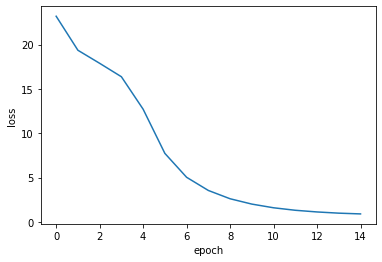

In [53]:
plt.plot(np.arange(num_epochs), train_loss_results)
plt.ylabel('loss')
plt.xlabel('epoch');

# 7. Results

To test our model, we define a set of sentences in English. To translate the sentences, we first preprocessed and embedded the sentences the same way we did with the training and validation sets. Next, we passed the embedded sentences through the encoder RNN to get the hidden and cell states. Starting with the special `<start>` token, we used this token and the encoder network's final hidden and cell states to get the one-step prediction and updated hidden and cell states from the decoder. Afterward, we created a loop to get the next step prediction and updated hidden and cell states from the decoder, using the most recent hidden and cell states. The loop is terminated when the `<end>` token is emitted or when the sentence has reached a defined maximum length. Finally, we decoded the output token sequence into Portuguese text.

The translations that were obtained are reasonably good. An interesting and more complex example was the input ‘are you still at home?’. A question has very clear syntax rules and some of them are language-specific. The returned translation ‘ainda esta em casa?’ showed that the model was able to capture those specificities.

In [54]:
english_test = ['that is not safe .',
                 'this is my life .',
                 'are you still at home ?',
                 'it is very cold here .']

In [55]:
english_test_emb = embed_english(split_english(tf.data.Dataset.from_tensor_slices((english_test, portuguese_token_train[:len(english_test),:])))).map(map_maxlen).batch(1)

In [56]:
total_output=[]

for x, y in english_test_emb:
    hidden_state, cell_state = encoder_model(x)
    output_decoder = decoder_model(inputs = np.tile(word_index['<start>'], (1, 1)), hidden_state = hidden_state, cell_state = cell_state)
    output=[]
    output.append(output_decoder)
    for i in range(14):
        output_decoder = decoder_model(inputs = tf.math.argmax(output_decoder, axis=2), hidden_state = hidden_state, cell_state = cell_state)
        if tf.math.argmax(output_decoder, axis=2).numpy()[0][0] == 2: # <end> character
            break
        output.append(output_decoder)
    total_output.append(output)

In [57]:
total_output_trans = []
for j in range(len(english_test)):
    output_trans = []
    for i in range(len(total_output[j])):
        output_trans.append(tf.math.argmax(total_output[j][i], axis=2).numpy()[0][0])
    total_output_trans.append(output_trans)

In [58]:
output_trans = np.array([np.array(xi) for xi in total_output_trans], dtype=object)

In [59]:
portuguese_trans_batch=[]
inv_word_index = {v: k for k, v in word_index.items()}
for i in range(output_trans.shape[0]):
    portuguese_trans_batch.append(' '.join(list(np.vectorize(inv_word_index.get)(output_trans[i]))))

In [60]:
list(english_test)

['that is not safe .',
 'this is my life .',
 'are you still at home ?',
 'it is very cold here .']

In [61]:
portuguese_trans_batch

['nao e seguro .',
 'e a minha vida .',
 'ainda esta em casa ?',
 'muito frio aqui .']

# 8. Conclusion

The architecture of the NMT model is quite challenging to work with and requires a significant amount of customization, for instance, in its training procedure. We used the principle of Transfer Learning when embedding the English sequences using a pre-trained embedding in a very large corpus. On the other side, we developed our own embedding for the Portuguese language used as input for the decoder network. The encoder and decoder RNNs were kept as simple as possible, as the model is computationally expensive to train.

We generated translations from English text to Portuguese without providing anything more than sentence pairs in English and Portuguese to train our model. The model understood affirmation and negation, important syntax distinctions, as in building an interrogative type of clause, and was able to interpret grammatical rules such as subject–auxiliary inversion, often used in English, that do not translate directly to Portuguese.

This approach can be extended by increasing the depth of the model with more recurrent layers and the number of units in each layer. Hyperparameters such as the batch size can be tuned to increase accuracy. A wider range of attention strategies can also be tested.

# 9. References

[[1]](https://arxiv.org/abs/1609.08144) [Wu et al., 2016] Wu, Y., Schuster, M., Chen, Z., Le, Q. V., Norouzi, M., Macherey, W., Krikun,M., Cao, Y., Gao, Q., Macherey, K., Klingner, J., Shah, A., Johnson, M., Liu, X., ŁukaszKaiser, Gouws, S., Kato, Y., Kudo, T., Kazawa, H., Stevens, K., Kurian, G., Patil, N., Wang,W., Young, C., Smith, J., Riesa, J., Rudnick, A., Vinyals, O., Corrado, G., Hughes, M., andDean, J. (2016). Google’s neural machine translation system: Bridging the gap between humanand machine translation.

[[2]](https://arxiv.org/abs/1412.2007) [Jean et al., 2015] Jean, S., Cho, K., Memisevic, R., and Bengio, Y. (2015). On using very largetarget vocabulary for neural machine translation.

[[3]](https://towardsdatascience.com/generating-text-with-recurrent-neural-networks-based-on-the-work-of-f-pessoa-1e804d88692d) https://towardsdatascience.com/generating-text-with-recurrent-neural-networks-based-on-the-work-of-f-pessoa-1e804d88692d

[[4]](https://tfhub.dev/google/tf2-preview/nnlm-en-dim128) https://tfhub.dev/google/tf2-preview/nnlm-en-dim128

[[5]](https://www.kaggle.com/luisroque/engpor-sentence-pairs) https://www.kaggle.com/luisroque/engpor-sentence-pairs

[[6]](https://towardsdatascience.com/transfer-learning-and-data-augmentation-applied-to-the-simpsons-image-dataset-e292716fbd43) https://towardsdatascience.com/transfer-learning-and-data-augmentation-applied-to-the-simpsons-image-dataset-e292716fbd43

[[7]](https://arxiv.org/pdf/1409.0473.pdf) [Bahdanau et al., 2016] Bahdanau, D., Cho, K., and Bengio, Y. (2016). Neural machine translationby jointly learning to align and translate.

[[8]](https://arxiv.org/pdf/1508.04025v5.pdf) [Luong et al., 2015] Luong, M.-T., Pham, H., and Manning, C. D. (2015). Effective approaches to attention-based neural machine translation.